# Try to reconfigure OpSim for other cadence

*Evenly distribute and include the galactic plane*

In [9]:
from OpSim import OpSim
from astropy.coordinates import SkyCoord
from astropy import units
import numpy as np

import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/minion_1016_sqlite.db' #for the OpSim database   
OpS.getAllOpSimFields()

getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


In [3]:
print(OpS.Nobs[1])

180.0


In [4]:
print(np.max(OpS.Nobs[np.where(OpS.Nobs < 5000)]))

922.0


<IPython.core.display.Javascript object>


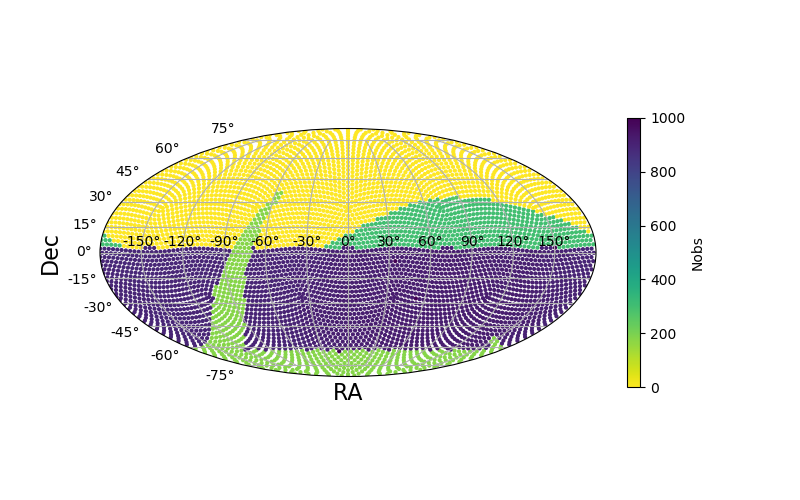

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


In [10]:
coords = SkyCoord(OpS.RA, OpS.Dec, unit=(units.degree, units.degree),frame='icrs')

RAwrap = coords.ra.wrap_at(180.*units.degree).degree
Decwrap = coords.dec.wrap_at(180.*units.degree).degree

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"}, figsize=(8,5))
ax.grid(True)
ax.set_xlabel("RA",fontsize=16)
ax.set_ylabel("Dec",fontsize=16)
mlw = ax.scatter(np.array(RAwrap).ravel()*np.pi/180., 
                 np.array(Decwrap).ravel()*np.pi/180., 
                 c=OpS.Nobs, #probably want this in a given filter, but that takes a long time to gather
                 cmap='viridis_r', s = 4, vmin=0, vmax=1000)
cbar = f.colorbar(mlw, shrink=0.7)
cbar.set_label(r'Nobs')


### Take only the fields that are observed and get their dates

In [6]:
observed = np.where(OpS.Nobs > 0)
print(len(observed[0]))

3339


*There will be this many observations in each of these fields*

*Neglect the fields with the very large number of obs -- is this a bug or because of overlap and/or a planned revisit?*

In [27]:
Nfields = len(observed[0])
Nobs = OpS.Nobs[observed]

bad = np.where(Nobs > 5000)
good = np.where(Nobs < 5000)
#print(bad, Nobs[bad])
Nobs[bad] = np.max(Nobs[good])
#print(Nobs[bad])

NtotalObs = np.sum(Nobs)
print("Nfields, NtotalObs, NObsPerField = ",Nfields, NtotalObs, NtotalObs/Nfields)

Nfields, NtotalObs, NObsPerField =  3339 2338183.0 700.2644504342618


### From above, we want about 700 observations per field. 

*But how do we distribute them??*

In [7]:
#this takes a long time to run through...
filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']
for i in OpS.fieldID[observed][0:2]:
    print(int(i))
    OpS.setDates(int(i), filters)


1
2


In [11]:
print(OpS.NobsDates[1])
print(OpS.Nobs[1])
print(OpS.obsDates)

{'u_': 30, 'g_': 30, 'r_': 30, 'i_': 30, 'z_': 30, 'y_': 30}
180.0
[{}
 {'u_': array([  3.16      ,   5.14099537,   6.33706019,  33.1227662 ,
        33.13032407,  33.13787037,  33.18326389,  33.36695602,
        58.12262731,  58.22488426,  58.23376157,  58.24265046,
        58.28354167,  59.1781713 ,  59.25375   ,  59.32090278,
        59.36052083,  87.01248843,  87.10255787,  87.10877315,
        87.12609954,  87.17155093,  87.23400463,  87.24556713,
        87.34240741,  88.07768519,  90.05314815,  90.13106481,
       119.99320602, 120.0290162 ]), 'g_': array([  6.20086806,  27.18863426,  27.20460648,  29.31055556,
        29.31321759,  29.35592593,  29.35680556,  32.07114583,
        32.07292824,  37.34625   ,  37.36048611,  55.05351852,
        55.0597338 ,  55.09175926,  55.10819444,  83.11884259,
        84.0490162 ,  84.11443287,  85.01674769,  85.09114583,
        85.15605324,  86.14069444,  89.0630787 ,  89.06930556,
        89.15123843,  89.25664352,  89.31858796, 112.047673